In [2]:
#@title Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses
import tensorflow_datasets as tfds
#from google.colab import files

from matplotlib import image
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random as rd
import cv2
import csv

In [1]:
!pip install tensorflow
import tensorflow

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
#@title Hyperparamètres
classes = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Suprise", "Neutral"]
Na = len(classes)
maxNbrImagesForEachClasses = float('inf')
h = 48
l = 48
p = 1
input_shape = (h, l, p)

epochs = 5
batch_size = 128
validation_size = 0.1

In [4]:
#@title Fonction utils
import numpy as np
import cv2
import matplotlib.pyplot as plt

def afficher(image):
    if len(image.shape) == 3:
        if image.shape[2] == 3:  # (h,l,3)
            plt.imshow(image)
        elif image.shape[2] == 1:  # (h,l,1)->(h,l)
            image2 = image
            plt.imshow(tf.squeeze(image))
    elif len(image.shape) == 2:  # (h,l)
        plt.imshow(image)


def predir(modele, image):
    # Return output of image from modele
    return modele.predict(np.array([image]))[0, :]


def normAndResize(image, input_shape):
    # For an array image of shape (a,b,c) or (a,b), transform it into (h,l,p). Also normalize it.

    h, l, p = input_shape
    # resize for h and l                                       #
    image = cv2.resize(image, dsize=(h, l), interpolation=cv2.INTER_CUBIC)
    # if we want (h,l,3) -> (h,l,1) , we first transform it in to (h,l) (grey the image)
    if len(image.shape) == 3 and p == 1 and image.shape[2] != 1:
        image = image.mean(2)
    image = np.reshape(image, (h, l, p))  # restore third dimension
    image = image.astype("float32")
    image = image/255  # normalisation

    return image


def selectFace(image):
    #Return a face identified on an colored image

    #Import cv2 face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

    #Face detection is made on gray images
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.3, 5) #This return a list of tuple locating faces on image
    
    #The face returned is the first face detected on the image (if exists)
    if faces != []:
        x,y,w,h = faces[0]
        face = image[y:y+h, x:x+w]
        return face

In [6]:
#@title Load data as array
nbrImages = 35887
maxNbrImages = 10000000000
emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Suprise", "Neutral"]

def traitement(a,b,c):  #For testing
	pass
	# arr = strToArray(b)
	# print(a)
	# plt.imshow(arr)
	# plt.show()
	# pass

def strToArray(string):  #Fer2013 provides images as string so it needs to be transformed
	A = []
	lenght = len(string)
	i=0
	nbr = ""

	while i<lenght:
		car = string[i]

		if car != " ":
			nbr += car
		else:
			A.append(int(nbr))
			nbr = ""
		i+=1
	A.append(int(nbr))
	
	A = np.array(A)
	A = np.reshape(A, (48, 48))

	return A



#LOAD DATA AS ARRAY
X = []
Y = []

filename = "/content/drive/MyDrive/Colab Notebooks/facial emotion recognition/fer2013.csv"
filename = "data/fer2013/fer2013.csv"

with open(filename,'r',encoding='utf-8') as file:
	
	csv_reader = csv.reader(file, delimiter=",")
	next(csv_reader)  								#Passe la ligne de titre
	
	i=0
	for row in csv_reader:

		i+=1
		if i>maxNbrImages: break
		
		emotionNbr, stringImage, typeImage = row
		traitement(emotionNbr, stringImage, typeImage)
		image = normAndResize(strToArray(stringImage), input_shape)

		X.append(image)
		Y.append(emotionNbr)

		print(f"Image {i} sur {nbrImages} chargée", end='\r')

X = np.array(X)
N = len(X)

Y = np.array(Y)
Y = keras.utils.to_categorical(Y)

FileNotFoundError: [Errno 2] No such file or directory: 'data/fer2013/fer2013.csv'

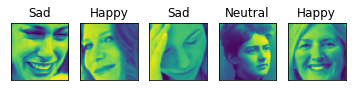

In [28]:
#@title Visualisation
N=5
plt.figure()
for i in range(N):
    k = rd.randrange(X.shape[0])
    plt.subplot(1, N, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    afficher(X[k])
    plt.title(classes[np.argmax(Y[k])])
plt.show()

<ipython-input-25-ac46f3f204c7>:50: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if faces != []:


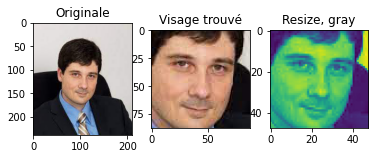

In [29]:
#Comparison on Cagnol test image for test
cagnol = plt.imread("cagnol.jpg")
cagnolFace = selectFace(cagnol)
cagnolFaceForInput = normAndResize(cagnolFace, input_shape)

plt.subplot(131)
plt.title("Originale")
afficher(cagnol)

plt.subplot(132)
plt.title("Visage trouvé")
afficher(cagnolFace)

plt.subplot(133)
plt.title("Resize, gray")
afficher(cagnolFaceForInput)


In [30]:
#Images et labels
print('X:', X.shape)
print('Y:', Y.shape)

X: (35887, 48, 48, 1)
Y: (35887, 7)


In [7]:
#@title Modèle
class MyModel(keras.Model):

    def __init__(self, input_shape):
        super(MyModel, self).__init__()
        self.conv2D1 = keras.layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape)
        self.conv2D2 = keras.layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu')
        self.conv2D3 = keras.layers.Conv2D(128, kernel_size = (3, 3), activation = 'relu')
        self.maxPooling = keras.layers.MaxPooling2D(pool_size = 2)
        self.flatten = keras.layers.Flatten()
        self.Dense1 = keras.layers.Dense(64, activation = 'relu')
        self.Dense2 = keras.layers.Dense(Na, activation = 'softmax')


    def call(self, x):
        y = self.conv2D1(x)
        y = self.maxPooling(y)
        y = self.conv2D2(y)
        y = self.maxPooling(y)
        y = self.conv2D3(y)
        y = self.maxPooling(y)
        y = self.flatten(y)
        y = self.Dense1(y)
        y = self.Dense2(y)
        return y
    
    def predir(self, monImage):
        return self.predict(np.array([monImage]))[0,:]

    def compile_o(self):
        self.compile(optimizer = 'adam', loss=losses.categorical_crossentropy, metrics = ['accuracy'])

myModel = MyModel(input_shape)
myModel.compile_o()

[0.12694494 0.00185027 0.16615286 0.2684518  0.18009424 0.07906247
 0.17744346]
[0.05335368 0.00411757 0.06580067 0.1750659  0.11889929 0.00182784
 0.58093494]


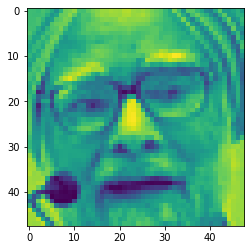

In [43]:
theImage = X[1]
afficher(theImage)
print(predir(myModel, theImage))
print(predir(myModel, cagnolFaceForInput))

In [8]:
#Entrainement

history = myModel.fit(X, Y, epochs=epochs, validation_split=0.05)

myModel.save('modelBadFast')

KeyError: 'pop from an empty set'

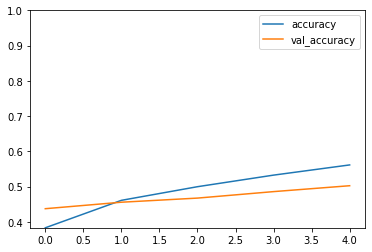

In [35]:
#Affichage de l'historique de l'apprentissage
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.ylim([min(history.history['val_accuracy']+history.history['accuracy']), 1])
plt.show()

In [38]:
# myModel = keras.models.load_model("modeleTest")
# print(myModel.predict(np.array([theImage]))[0,:])

[2.96738029e-01 1.24476401e-05 2.17953697e-01 1.91844806e-01
 1.76624253e-01 1.78373352e-06 1.16824925e-01]
[6.6510475e-01 8.1453304e-04 5.7720199e-02 1.3529294e-04 2.1474548e-01
 2.6716415e-03 5.8808159e-02]
